# CSCI 4622 Machine Learning Final Project

**Authors:**  
+ Kaitlin Coleman _[kaitlin.coleman@colorado.edu]()_
+ Jot Kaur _[jot.kaur@colorado.edu]()_
+ Alex Ho _[alex.ho@colorado.edu]()_
+ Liam Nestelroad _[liam.nestelroad@colorado.edu]()_

In [1]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
from time import time

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

%matplotlib inline


## Summary

The goal of this project is to create a predictive model for Alzheimer’s disease (AD) based on existing data on the disease. Alzheimer’s disease is one of the most common forms of dementia and affects approximately 5.5 Million Americans. Alzheimer’s often begins years before symptoms appear, making early detection through traditional methods very difficult (Alzheimer’s Association). This is where the new age of technology and advancements in computer science can fill gaps where traditional methods lack, using data to make inferences that humans may not be able to. Our group was fascinated with this meaningful and important application of machine learning, and wanted to learn how machine learning can assist in the medical field, specifically with such a detrimental disease such as Alzheimer’s. 

## Data

For this project we will use a neuroimaging data set collected under the OASIS (Open Access Series Imaging Studies) Brains project. The OASIS Brains project was developed to help make neuroimaging datasets freely available to the scientific community in order to enrich knowledge and facilitate future discoveries in clinical neuroscience. The dataset we will be using is called OASIS-3 and it is a longitudinal neuroimaging, clinical, cognitive, and biomarker dataset for normal aging and Alzheimer’s Disease. In this project we will use two different sets of data to apply two different machine learning methods. The first is a longitudinal brain imaging scan study and the second is a cross-sectional brain imaging study.  


The first dataset we will use the __Longitudinal__ study. This study includes data from 374 MRI scans of 186 subjects. The subjects range from ages 60 to 96 and all data was acquired on the same scanner. Each row of the dataset is a different MRI scan and consists of 15 columns of data that describe information about the subject’s demographic information and results from the scan. The first four columns are the subject ID, MRI ID, (both a combination of numbers and characters) and resulting classification of being “demented” or “nondemented” indicating the onset of Alzheimer’s or not, and the number of the participant’s visit. The next five columns describe demographic information about the subject including gender as M or F, their dominant hand as R or L, their age, years of education they have, and their socioeconomic status (SES) as classified into categories from 1 (highest status) to 5 (lowest status) (Hollingshead, 1957). The sixth column is a Mini-Mental State Examination Score (MMSE) which ranges from a score of 0 (worst) to 30 (best) (Folstein, Folstein, & McHugh, 1975). Next, is a Clinical Dementia Rating which consists of a scale 0=no dementia, 0.5=very mild AD, 1 = mild AD, 2 = moderate AD, 3 = severe AD (Morris, 1993).  Next, is a column of Atlas Scaling Factor (ASF) which is a unitless computed volume scaling factor of the brain. This score should be proportional to the next column the Estimated Total Intracranial Volume (eTIV) in cm. cubed (Buckner et al., 2004). Finally, the last column is the Normalized Whole Brain Volume (nWBV) described as a percentage (Fotenos et al., 2005).   


The second dataset we will use is the cross-sectional brain imaging study. This study includes data from 437 subjects that each participated in one MRI scan. The subjects in this study range from ages 18 to 96. The data provided is organized in the same way and contains the same content as described in the previous study.



## Data Cleaning

Most of the data cleaning was going through and imuting missing values with the column mean, normalizing numerical data, stratifying catigorical columns, and removing unnecessary information as can be seen below:

In [2]:
CROSS_SECTIONAL = 'data/oasis_cross-sectional.csv'
LONGITUDINAL = 'data/oasis_longitudinal.csv'

# Load in data from CSV
data_l = pd.read_csv(LONGITUDINAL) 
data_cs = pd.read_csv(CROSS_SECTIONAL)

In [3]:
# Initial data preview
data_l.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [4]:
data_cs.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [5]:
# Changes the column name so there is consistancy between data frames.
data_cs.rename(columns={'Educ':'EDUC'}, inplace=True)
data_cs.rename(columns={'ID':'Subject ID'}, inplace=True)
data_l.rename(columns={'MR Delay':'Delay'}, inplace=True)

In [6]:
# delete obsolete data columns
del data_l['MRI ID']
del data_cs['Delay']
del data_l['Delay']

In [7]:
# Remove rows which has NaN in the CDR column
# https://www.datasciencelearner.com/pandas-dropna-remove-nan-rows-python/
data_cs.dropna(subset=['CDR'], inplace=True)

In [8]:
# Change the Group column to contain only binary values for binary classification
data_l['Group'] = data_l['Group'].replace(['Converted'], ['Demented']) # Target variable
data_l['Group'] = data_l['Group'].replace(['Demented', 'Nondemented'], [1,0]) # Target variable

# https://techoverflow.net/2021/04/24/how-to-replace-pandas-values-by-nan-by-threshold/
data_cs["CDR"][data_cs['CDR'] > 0] = 1
data_cs["CDR"][data_cs['CDR'] == 0.0] = 0

# https://www.geeksforgeeks.org/change-the-data-type-of-a-column-or-a-pandas-series/
data_cs = data_cs.astype({'CDR':int})

In [9]:
# filling missing entries with column means for each data frame.
#https://thispointer.com/pandas-replace-nan-with-mean-or-average-in-dataframe-using-fillna/
sub_k = ['EDUC','SES','MMSE']
for k in sub_k:
    data_l[k].fillna(value=data_l[k].mean(), inplace=True)
    data_cs[k].fillna(value=data_l[k].mean(), inplace=True)

In [10]:
# Encoding catagorical columns as values 
# https://izziswift.com/label-encoding-across-multiple-columns-in-scikit-learn/
encodings = ['M/F', 'Hand', 'Subject ID']
for encode in encodings:
    le = LabelEncoder()
    data_l[encode] = data_l[[encode]].apply(le.fit_transform)
    data_cs[encode] = data_cs[[encode]].apply(le.fit_transform)

In [11]:
data_cs.head()

,Subject ID,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,0,0,74,2.0,3.0,29.0,0,1344,0.743,1.306
1,1,0,0,55,4.0,1.0,29.0,0,1147,0.810,1.531
2,2,0,0,73,4.0,3.0,27.0,1,1454,0.708,1.207
8,3,1,0,74,5.0,2.0,30.0,0,1636,0.689,1.073
9,4,0,0,52,3.0,2.0,30.0,0,1321,0.827,1.329


In [12]:
from sklearn.model_selection import train_test_split

l_Y = data_l['Group'].values
l_X = data_l[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']]

cs_Y = data_cs['CDR'].values
cs_X = data_cs[['M/F', 'Hand', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']]

# splitting into testing and training subsets
l_X_train, l_X_test, l_y_train, l_y_test = train_test_split(
    l_X, l_Y, random_state=0, shuffle=True)

cs_X_train, cs_X_test, cs_y_train, cs_y_test = train_test_split(
    cs_X, cs_Y, random_state=0, shuffle=True)

# Normalize numerical columns with the minmaxscaler function
# https://www.geeksforgeeks.org/normalize-a-column-in-pandas/
scaler = MinMaxScaler().fit(l_X_train)
l_X_train = pd.DataFrame(scaler.transform(l_X_train))
l_X_test = pd.DataFrame(scaler.transform(l_X_test))

scaler = MinMaxScaler().fit(cs_X_train)
cs_X_train = pd.DataFrame(scaler.transform(cs_X_train))
cs_X_test = pd.DataFrame(scaler.transform(cs_X_test))

In [13]:
# Cleaned data preview
l_X_train.describe()

,0,1,2,3,4,5,6,7
count,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000
mean,0.430108,0.433595,0.504111,0.375435,0.900563,0.435632,0.449924,0.442260
std,0.495981,0.202274,0.171476,0.275057,0.131491,0.201240,0.190275,0.197637
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.297297,0.352941,0.250000,0.884615,0.290011,0.301047,0.306108
50%,0.000000,0.432432,0.470588,0.250000,0.961538,0.417707,0.455497,0.436080
75%,1.000000,0.567568,0.588235,0.500000,1.000000,0.558456,0.581152,0.577415
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
data_l.head()

,Subject ID,Group,Visit,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,0,1,1,0,87,14,2.000000,27.0,0.0,1987,0.696,0.883
1,0,0,2,1,0,88,14,2.000000,30.0,0.0,2004,0.681,0.876
2,1,1,1,1,0,75,12,2.460452,23.0,0.5,1678,0.736,1.046
3,1,1,2,1,0,76,12,2.460452,28.0,0.5,1738,0.713,1.010
4,1,1,3,1,0,80,12,2.460452,22.0,0.5,1698,0.701,1.034


## EDA

We will summarize our dataset with a few key plots and statistics to better understand our data. First, we will determine the average dementia cases for each given feature with 95% confidence intervals. For binary traits such as gender, we will conduct t-tests to find if there is a statistically significant relationship between these features and dementia cases. With features with ranges, we will plot the data with the feature’s range on the x-axis and the number of dementia cases on the y-axis. We will also create scatter-plots with the various features and the dementia level to visually find correlations in that way. To statistically find the significance, we will conduct chi-squared tests and Factorial Anova tests on the levels of dementia and features. This analysis will help us determine which features are significant.We will use Spearman's correlation coefficient between the various features to find correlating features and their relationships. Although these are many plots and statistical analyses, we will show the most interesting and significant in the report. 

### General Information About the Data

In [15]:
data_cs.describe()

,Subject ID,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,235.000000,235.000000,235.0,235.000000,235.000000,235.000000,235.00000,235.000000,235.000000,235.000000,235.000000
mean,117.000000,0.336170,0.0,72.344681,3.178723,2.488292,27.06383,0.425532,1459.497872,0.749132,1.216511
std,67.982841,0.473406,0.0,12.091369,1.311510,1.074167,3.69687,0.495479,160.368070,0.047906,0.129427
min,0.000000,0.000000,0.0,33.000000,1.000000,1.000000,14.00000,0.000000,1123.000000,0.644000,0.881000
25%,58.500000,0.000000,0.0,66.000000,2.000000,2.000000,26.00000,0.000000,1348.000000,0.713500,1.133500
50%,117.000000,0.000000,0.0,73.000000,3.000000,2.460452,29.00000,0.000000,1447.000000,0.747000,1.213000
75%,175.500000,1.000000,0.0,81.000000,4.000000,3.000000,30.00000,1.000000,1548.000000,0.784000,1.302000
max,234.000000,1.000000,0.0,96.000000,5.000000,5.000000,30.00000,1.000000,1992.000000,0.847000,1.563000


In [16]:
data_l.describe()

,Subject ID,Group,Visit,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,373.0,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000
mean,73.343164,0.490617,1.882038,0.428954,0.0,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,43.625116,0.500583,0.922843,0.495592,0.0,7.640957,2.876339,1.104665,3.673329,0.374557,176.139286,0.037135,0.138092
min,0.000000,0.000000,1.000000,0.000000,0.0,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,36.000000,0.000000,1.000000,0.000000,0.0,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,71.000000,0.000000,2.000000,0.000000,0.0,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,111.000000,1.000000,2.000000,1.000000,0.0,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,149.000000,1.000000,5.000000,1.000000,0.0,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


### Data Distrobution Histograms

DATA_L


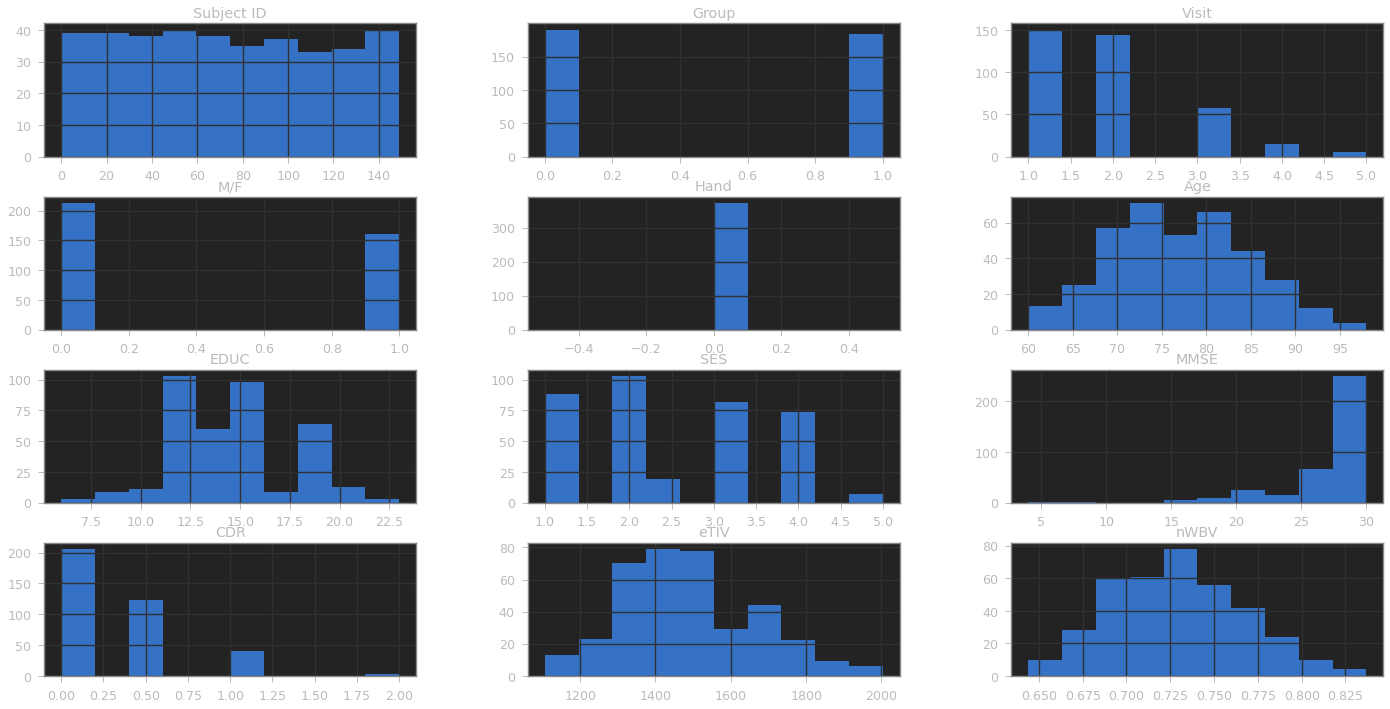

In [17]:
def plot_hist(df):
    fig, axes = plt.subplots(len(df.columns)//3, 3, figsize=(24, 12))
    i = 0
    for triaxis in axes:
        for axis in triaxis:
            try:
                df.hist(column = df.columns[i], bins = 10, ax=axis)
            except ValueError as e:
                pass
            i = i+1

    plt.show()
print("DATA_L")
plot_hist(data_l)


DATA_CS


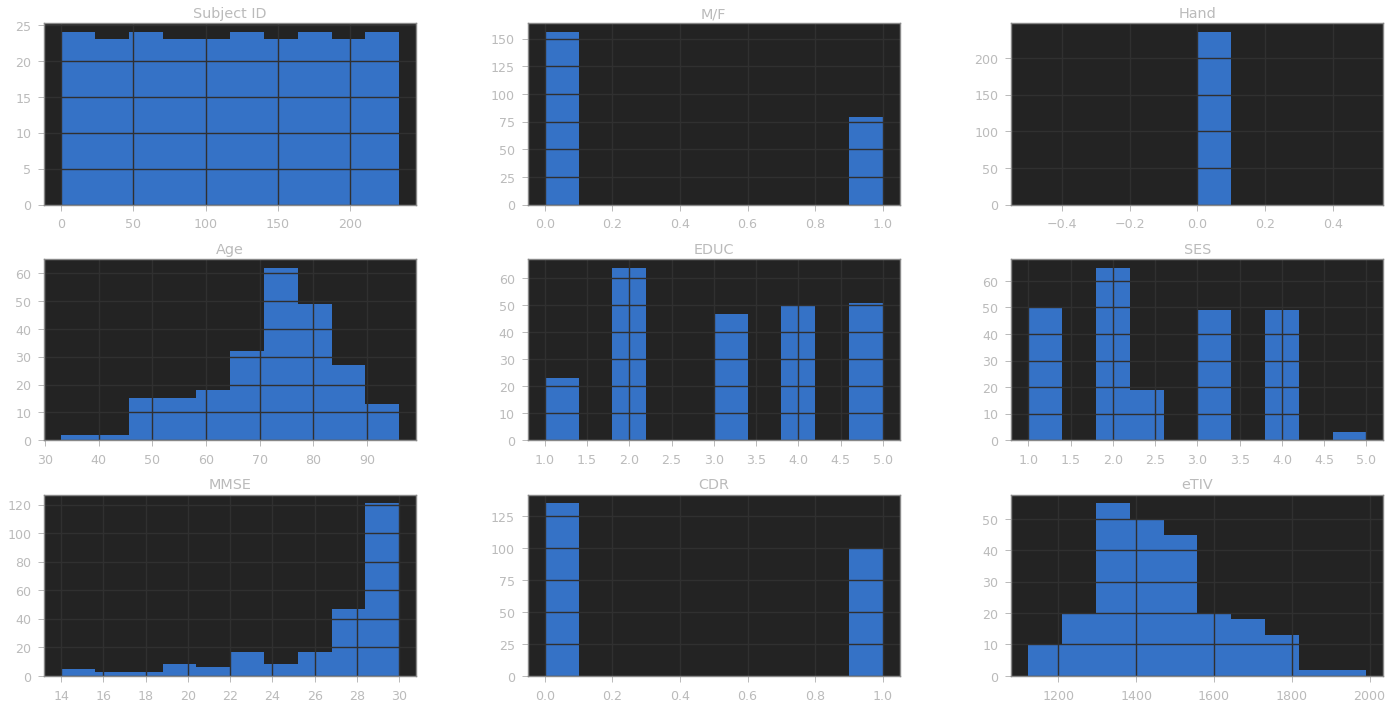

In [18]:
print("DATA_CS")
plot_hist(data_cs)
plt.show()

### Feature Corrolations

In [19]:
features = ['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']
features2 = features + ['CDR']

# correlation matrix
cm_l = data_l[features2].corr()
cm_cs = data_cs[features2].corr()

cm_l

,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF,CDR
M/F,1.000000,-0.037726,0.089279,-0.044525,-0.166521,0.572549,-0.249618,-0.561647,0.202140
Age,-0.037726,1.000000,-0.027886,-0.046665,0.055607,0.042348,-0.518359,-0.035067,-0.026257
EDUC,0.089279,-0.027886,1.000000,-0.708680,0.194454,0.257015,-0.012200,-0.241752,-0.153121
SES,-0.044525,-0.046665,-0.708680,1.000000,-0.146913,-0.254271,0.089436,0.246673,0.073393
MMSE,-0.166521,0.055607,0.194454,-0.146913,1.000000,-0.031789,0.341857,0.039494,-0.679837
eTIV,0.572549,0.042348,0.257015,-0.254271,-0.031789,1.000000,-0.210122,-0.988877,0.022819
nWBV,-0.249618,-0.518359,-0.012200,0.089436,0.341857,-0.210122,1.000000,0.213476,-0.344819
ASF,-0.561647,-0.035067,-0.241752,0.246673,0.039494,-0.988877,0.213476,1.000000,-0.029340
CDR,0.202140,-0.026257,-0.153121,0.073393,-0.679837,0.022819,-0.344819,-0.029340,1.000000


In [20]:
cm_cs

,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF,CDR
M/F,1.000000,-0.024062,0.068010,-0.049511,-0.019639,0.554889,-0.118417,-0.544050,0.134511
Age,-0.024062,1.000000,-0.207094,0.154165,-0.252123,0.040104,-0.720340,-0.034460,0.314953
EDUC,0.068010,-0.207094,1.000000,-0.722549,0.297317,0.147271,0.194903,-0.126571,-0.235910
SES,-0.049511,0.154165,-0.722549,1.000000,-0.228845,-0.177188,-0.113612,0.160048,0.168607
MMSE,-0.019639,-0.252123,0.297317,-0.228845,1.000000,-0.005727,0.469599,0.014133,-0.640151
eTIV,0.554889,0.040104,0.147271,-0.177188,-0.005727,1.000000,-0.218872,-0.989741,0.130434
nWBV,-0.118417,-0.720340,0.194903,-0.113612,0.469599,-0.218872,1.000000,0.219154,-0.488485
ASF,-0.544050,-0.034460,-0.126571,0.160048,0.014133,-0.989741,0.219154,1.000000,-0.127353
CDR,0.134511,0.314953,-0.235910,0.168607,-0.640151,0.130434,-0.488485,-0.127353,1.000000


### PCA

In [21]:
from sklearn.decomposition import PCA

l_pca = PCA(n_components='mle')
l_pca.fit(l_X_train)

print(l_pca.explained_variance_ratio_)

[0.54436003 0.18425569 0.11156736 0.07510575 0.04368572 0.02288415
 0.01729774]


## Models

Given that this is primarly a classification problem on the wheather or not a patient will have Alzheimer's Disease, most of our models will be classfiers and regressors. To begin, all of the models will be thrown into a pipeline with will first begin with a PCA decomposition. This pipeline will then be passed into a grid search cross validator to tune over the hyper parameters in each model. For those that can take in more precise parameters, we then implement a random search cross validator to really hone in on the optimal configurations. In addition to running the standard classification algorithms, an unsuppervised clustering algorithm will be included to show how inefficient they are at binary types of problems. The followning machine learning algorithms will be ran:

+ SVM
+ Random Forests
+ K Nearest Neighbors
+ Logistic Regression
+ K Means Clustering

At the end, the best parameters for each algorithm will be presented along with the resulting f1 score. We chose to use f1 over a ROC AUC scoring becuase we would rather have fewer false negatives and more false positives. Telling someone they have Alzheimer's is some tough news to break, but if it were us, we'd rather know and not have it rather than not know and be caught off guard.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, auc, roc_curve, recall_score
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import expon, norm

In [23]:
results = {}

def get_grid_svm(param_grid, model, X, y, X_test, y_test):
    """
    Create GridSearchCV with pipeline and the grid search parameters given above using "accuracy" for scoring. 
    """ 
    
    pipeline_svm = make_pipeline(PCA(), model)
    
    # YOUR CODE HERE
    grid_svm = GridSearchCV(
        pipeline_svm, 
        param_grid, 
        scoring="f1_weighted",
        cv=5,
        n_jobs=6)

    grid_svm.fit(X, y)

    best_params = grid_svm.best_params_
    best_score = grid_svm.best_score_
    accuarcy = grid_svm.score(X_test, y_test)

    print("Grid Search:")
    print(f'best params:')
    pprint(best_params)
    print(f"best f1 score: {best_score}")
    print(f'Testing score: {accuarcy}\n')

    results[model] = {
        'grid': True,
        'best params': best_params,
        'best f1': best_score,
        'score': accuarcy
    }

    # print('results: ')
    # pprint(grid_svm.cv_results_)

def get_random_svm(param_rand, model, X, y, X_test, y_test):
   
    n_iter = 1000
    pipeline_svm = make_pipeline(PCA(), model)
    param_grid = param_rand

    random_svm = RandomizedSearchCV(
        pipeline_svm,
        param_grid,
        n_iter=n_iter,
        scoring="f1_weighted",
        cv=5,
        n_jobs=6 # you can change the n_jobs parameter to -1 if your system supports multi-prcoessing
    )
    random_svm.fit(X, y)

    best_params = random_svm.best_params_
    best_score = random_svm.score(X_test, y_test)
    accuarcy = random_svm.score(X_test, y_test)
    # Report best parameters and score from random search
    print("Random Search:")
    print(f'best params:')
    pprint(best_params)
    print(f"best f1 score: {best_score}")
    print(f'Testing score: {accuarcy}\n')

    # results[model] = {
    #     'grid': False,
    #     'best params': best_params,
    #     'best f1': best_score,
    #     'score': accuarcy
    # }

    # print('results: ')
    # pprint(random_svm.cv_results_)

### SVC

In [24]:
param_grid = [
        {
            'svc__kernel':['linear'], 
            'svc__C':[0.001, .01, .1, 1, 10, 100, 1000],
            'pca__n_components':[i for i in range(1, l_X_train.shape[1]+1)]
        },
        {
            'svc__kernel':['poly'], 
            'svc__degree': [2, 4, 6], 
            'svc__gamma':[0.1,0.5,1],
            'pca__n_components':[i for i in range(1, l_X_train.shape[1]+1)]
        },
        {
            'svc__kernel':['rbf', 'sigmoid'], 
            'svc__gamma':[0.001, .01, .1, 1, 10, 100, 1000], 
            'svc__C':[0.001, .01, .1, 1, 10, 100, 1000],
            'pca__n_components':[i for i in range(1, l_X_train.shape[1]+1)]
        },
    ]

param_rand = {
    'svc__kernel':['rbf'], 
    'svc__C':norm(10, .1), 
    'svc__gamma':norm(10, .1), 
    'pca__n_components':[i for i in range(1, l_X_train.shape[1]+1)]
}
mod = SVC(class_weight='balanced')

print("Logitudinal:")
get_grid_svm(param_grid, mod, l_X_train, l_y_train, l_X_test, l_y_test)
get_random_svm(param_rand, mod, l_X_train, l_y_train, l_X_test, l_y_test)

print("Cross Sectional:")
get_grid_svm(param_grid, mod, cs_X_train, cs_y_train, cs_X_test, cs_y_test)
get_random_svm(param_rand, mod, cs_X_train, cs_y_train, cs_X_test, cs_y_test)

Logitudinal:
Grid Search:
best params:
{'pca__n_components': 7, 'svc__C': 10, 'svc__gamma': 100, 'svc__kernel': 'rbf'}
best f1 score: 0.8987809623444356
Testing score: 0.8060657216869925

Random Search:
best params:
{'pca__n_components': 7,
 'svc__C': 10.00371484569351,
 'svc__gamma': 10.055906320290969,
 'svc__kernel': 'rbf'}
best f1 score: 0.8936170212765957
Testing score: 0.8936170212765957

Cross Sectional:
Grid Search:
best params:
{'pca__n_components': 8, 'svc__C': 1000, 'svc__kernel': 'linear'}
best f1 score: 0.8573331867879059
Testing score: 0.8136665642990499

Random Search:
best params:
{'pca__n_components': 8,
 'svc__C': 9.835458889727319,
 'svc__gamma': 9.76260635771604,
 'svc__kernel': 'rbf'}
best f1 score: 0.7289694135982855
Testing score: 0.7289694135982855



In [25]:
pprint(results)

{SVC(class_weight='balanced'): {'best f1': 0.8573331867879059,
                                'best params': {'pca__n_components': 8,
                                                'svc__C': 1000,
                                                'svc__kernel': 'linear'},
                                'grid': True,
                                'score': 0.8136665642990499}}


### Random Forests

In [26]:
random_grid = {
    'randomforestclassifier__max_features': ['auto', 'sqrt'],
    'randomforestclassifier__max_depth': [i for i in range(10, 100, 40)] + [None],
    'randomforestclassifier__min_samples_split': [5, 10],
    'randomforestclassifier__min_samples_leaf': [2, 4],
    'randomforestclassifier__bootstrap': [False],
    'pca__n_components':[i for i in range(1, l_X_train.shape[1]+1)]
}
mod_rf = RandomForestClassifier()

print("Logitudinal:")
get_grid_svm(random_grid, mod_rf, l_X_train, l_y_train, l_X_test, l_y_test)

print("Cross Sectional:")
get_grid_svm(random_grid, mod_rf, cs_X_train, cs_y_train, cs_X_test, cs_y_test)

Logitudinal:
Grid Search:
best params:
{'pca__n_components': 7,
 'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__min_samples_split': 5}
best f1 score: 0.8743052461173828
Testing score: 0.8076422058184977

Cross Sectional:
Grid Search:
best params:
{'pca__n_components': 5,
 'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__min_samples_split': 10}
best f1 score: 0.8049148820734269
Testing score: 0.8136665642990499



### Logistic Regression

In [27]:

param_grid_lr = {
    'logisticregression__C': np.logspace(-10, 5, 5000),
    'logisticregression__penalty':['l1', 'l2'],
    'pca__n_components':[i for i in range(1, l_X_train.shape[1]+1)]
}

param_rand_lr = {
    'logisticregression__C': norm(191.18608993192663, 5),
    'logisticregression__penalty':['l2'],
    'pca__n_components':[i for i in range(1, l_X_train.shape[1]+1)]
}

mod_lr = LogisticRegression()

print("Logitudinal:")
get_grid_svm(param_grid_lr, mod_lr, l_X_train, l_y_train, l_X_test, l_y_test)
get_random_svm(param_rand_lr, mod_lr, l_X_train, l_y_train, l_X_test, l_y_test)

print("Cross Sectional:")
get_grid_svm(param_grid_lr, mod_lr, cs_X_train, cs_y_train, cs_X_test, cs_y_test)
get_random_svm(param_rand_lr, mod_lr, cs_X_train, cs_y_train, cs_X_test, cs_y_test)

Logitudinal:
Grid Search:
best params:
{'logisticregression__C': 191.18608993192663,
 'logisticregression__penalty': 'l2',
 'pca__n_components': 8}
best f1 score: 0.798095446919635
Testing score: 0.8086840888066605

Random Search:
best params:
{'logisticregression__C': 191.52888823818319,
 'logisticregression__penalty': 'l2',
 'pca__n_components': 8}
best f1 score: 0.8086840888066605
Testing score: 0.8086840888066605

Cross Sectional:
Grid Search:
best params:
{'logisticregression__C': 76.27399171327818,
 'logisticregression__penalty': 'l2',
 'pca__n_components': 7}
best f1 score: 0.8730013924899669
Testing score: 0.7966101694915254

Random Search:
best params:
{'logisticregression__C': 192.95028422319837,
 'logisticregression__penalty': 'l2',
 'pca__n_components': 7}
best f1 score: 0.7966101694915254
Testing score: 0.7966101694915254



### K-Nearest Neighbor

In [28]:
tuned_parameters = [
    {
        'kneighborsclassifier__algorithm':['brute'],
        'kneighborsclassifier__weights':['uniform', 'distance'],
        'kneighborsclassifier__p': list(range(5)),
        'pca__n_components':[i for i in range(1, l_X_train.shape[1]+1)]
    },
    {
        'kneighborsclassifier__algorithm': ['ball_tree', 'kd_tree'],
        'kneighborsclassifier__leaf_size': list(range(10, 60, 10)),
        'kneighborsclassifier__weights':['uniform', 'distance'],
        'kneighborsclassifier__p': list(range(5)),
        'pca__n_components':[i for i in range(1, l_X_train.shape[1]+1)]

    }

]
mod_knn = KNeighborsClassifier()

print("Logitudinal:")
get_grid_svm(tuned_parameters, mod_knn, l_X_train, l_y_train, l_X_test, l_y_test)

print("Cross Sectional:")
get_grid_svm(tuned_parameters, mod_knn, cs_X_train, cs_y_train, cs_X_test, cs_y_test)


Logitudinal:
Grid Search:
best params:
{'kneighborsclassifier__algorithm': 'brute',
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'distance',
 'pca__n_components': 8}
best f1 score: 0.8384284519357423
Testing score: 0.8294767684411715

Cross Sectional:
Grid Search:
best params:
{'kneighborsclassifier__algorithm': 'brute',
 'kneighborsclassifier__p': 4,
 'kneighborsclassifier__weights': 'distance',
 'pca__n_components': 5}
best f1 score: 0.7837694531061361
Testing score: 0.8291256765833038



### K-Means Clustering

In [29]:

param_grid_kmc = {
    'kmeans__n_clusters': [2]
}

mod_kmc = KMeans()
print("Logitudinal:")
get_grid_svm(param_grid_kmc, mod_kmc, l_X_train, l_y_train, l_X_test, l_y_test)

print("Cross Sectional:")
get_grid_svm(param_grid_kmc, mod_kmc, cs_X_train, cs_y_train, cs_X_test, cs_y_test)


Logitudinal:
Grid Search:
best params:
{'kmeans__n_clusters': 2}
best f1 score: 0.5531550079318686
Testing score: 0.5938936949575246

Cross Sectional:
Grid Search:
best params:
{'kmeans__n_clusters': 2}
best f1 score: 0.45401152158976804
Testing score: 0.3915021105836718



## Results

In [38]:
scores = pd.DataFrame(results)
optimal = []

for k in results.keys():
    optimal.append(pd.DataFrame(resutls[key]))

KeyError: RandomForestClassifier()

## Conclusions